# Neural Network Optimization and Tuning

In this tutorial you will learn how to implement a number of optimization techniques in PyTorch along with other tuning methods, to effectively apply the gradients to update the network parameters. 

We will introduce the concepts of different methods, their motivation, as well as the the implementation details in Pytorch.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from collections import namedtuple
from IPython.display import Image
np.random.seed(2019)

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.__version__

'2.0.0'

The second version is the version of the Keras API implemented by tf.keras. Note that it ends with `-tf`, highlighting the fact that tf.keras implements the Keras API, plus some extra TensorFlow-specific features.

In [4]:
keras.__version__

'2.2.4-tf'

Introducing the Fashion-MNIST dataset. Instead of handwritten digits, this dataset contains images of 10 different **common clothing items**, hence the name **Fashion-MNIST** . Performance on MNIST saturates quickly with simple network architectures and optimization methods. This dataset is more difficult than MNIST and is useful to demonstrate the relative improvements of different optimization methods. 

Some of the characteristics are mentioned below.

- 28x28 images, each pixel intensity is represented by an integar rather than float
- 10 classes
- Single color channel (B&W)
- Centered objects
- 60000 training set members
- 10000 test set members

`keras` has a number of functions to load popular datasets in `keras.datasets`, of which the Fashion-MNIST is one. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [5]:
# If you have ssl issues, see the last answer in https://stackoverflow.com/questions/52805115/certificate-verify-failed-unable-to-get-local-issuer-certificate
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [6]:
X_train_full.shape

(60000, 28, 28)

In [7]:
X_train_full.dtype

dtype('uint8')

Creating a validation set of $5000$. Also we need to scale the pixel intensities. For simplicity, they are scaled by $255.0$, which also converts them into floating. In general, one may to preprocess is to center the data to have a mean of $0$, and normalize its scale to $[-1, 1]$ along each feature. This may help the ill-conditional covariance matrix of the features. One thing to note is that in this approach, the preprocessing statistics, such as the mean, should only be computed on the training data, and then applied to validation and testing, or just use a constant not obtained from training data - we cannot just normalize the validation and testing data themselves.

In [8]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test, y_test = X_test/255.0, y_test/255.0

The labels are the class IDs (represented as uint8), from 0 to 9. And here are the corresponding class names.

In [9]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

## Random examples from the Fashion-MNIST dataset

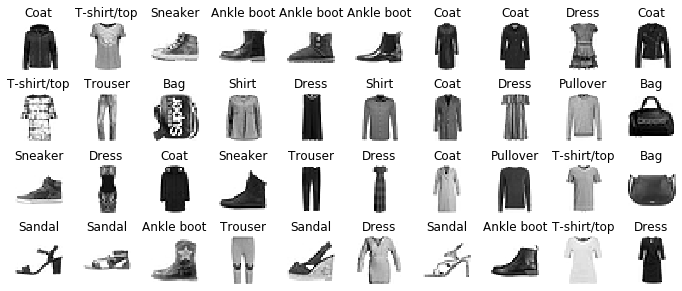

In [10]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

## Build a model

As we are more focussed on evaluating how the different optimization methods perform, we'll be constructing a very simple feedforward network. Although this following network is rather simple, it showcase the subclassing API of `keras`. The big deal here is that you can do pretty much anything you want in `call()` method: `for` loops, `if` statement, low-level `tensorflow` operations, or building dynamic graph. 

This extra flexibility does come at a cost: your model’s architecture is hidden within the call() method, so Keras cannot easily inspect it - you can use save_weights() and load_weights() to at least save and restore the model parameters, but you will need to save and restore everything else yourself, and you will not be able to use `callback`; it cannot save or clone it; and when you call the summary() method, you only get a list of layers, without any information on how they are connected to each other. Moreover, Keras cannot check types and shapes ahead of time, and it is easier to make mistakes. 

Another tip is that Keras models can be used just like regular layers, so you can easily combine them to build complex architectures.

In [11]:
class FashionModel(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.flatten = keras.layers.Flatten(input_shape=[28, 28])
        self.fc1 = keras.layers.Dense(64, activation="relu")
        self.fc2 = keras.layers.Dense(32, activation="relu")
        self.fc3 = keras.layers.Dense(10, activation="softmax")
    
    def call(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

## Let's write our *Trainer* - Perform mini-batch gradient Decent

- **What is it?** Performs update for every mini-batch of data, i.e. calculate gradient only using a small batch. Ultimately, it will go through the whole dataset multiple times. Each time is called an **epoch**.
    
- **Why?** On the one hand, Batch gradients that uses the whole dataset for one update is slow and intractable for large datasets to fit into memory; on the other hand, stochastic gradient descent that updates for each data has high variance in updates. So mini-batch is a good compromise. Indeed, for convex functions, convergence rate for one-sample SGD is $O(\frac{1}{\sqrt{k}})$, while for mini-batch updates with batches of size $b$ and number of steps $k$, the convergence rate is $O(\frac{1}{\sqrt{bk}}+\frac{1}{k})$ - although we perform $b$ times as many computations per iteration as one-sample SGD and hence get a degradation oAlso, matrix multiplication is faster. Why can we not simply loop through the data by batch, i.e. why we need randomness? The reason is if we loop through the data deterministically, we may get cyclic behavior. In other words, it is best that each batch we can an equally representative and diffuse data points so that we have good estimate of the gradients and loss.
    
- **What else to keep in mind?** The common mini-batch size are 32-256. When it is too small, it is too slow and high variance; when it is too big, it exceeds the memory capacity, is harder to escape from local minima and tends to decay in generalization.

Remember to **shuffle the dataset**, or it is possible that during training your neural net will pick up on that as a shortcut yet undesired way of learning.

In `keras`, setting the mini-batch size and the shuffle can be done in the `fit()` API; see examples below.

## Choosing the right divergence, or loss function

This is particularly important for classification, since typically a differentiable function is choosen to approximate the step loss prescribed by accuracy. The best of divergence is steep far from the optimum, but shallow at the optimum. One counter-example of this is if we choose to use L2 loss on top of the KL divergence for a classfication problem - this loss function is shallow far away from the optimum yet steep near the optimum, so it will be slow to converge as well as easy to miss the optimum - not a good choice!

In `keras`, both the loss function and the optimizer are specified when you compile the model; see below for implementation details.

# How to adjust Learning Rate - Smart Learning Rate and Optimization Steps

 - **What are these methods?**
     
    - **SGD with Nesterov's Accelerated Momentum**. Maintain a running average of all past steps, then update with the average instead of the current descent. The intuition is in directions in which the convergence is smooth, the average will have a large value; and in directions in which the estimate swings, the positive and negative swings will cancel out in the average (see comment below about the condition number of the Hessian matrix). Thus this will effectively mitigate the zigzag behavior around the target minimum. *The difference between Nesterov's method vs. traditional memuntum is that is changes the order of operations*: Nesterov takes the derivative after taking a further step in the past direction, then correction. Nesterov shows that this accelarate the convergence: the intuition being that, in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than using the gradient at the original position. 

    \begin{align}
    \Delta \textbf{W}^{(k)} &= \mu \Delta\textbf{ W}^{(k-1)} - \eta \nabla_W L(\textbf{W}^{(k-1)}+\mu\Delta W^{(k-1)})\\
    \textbf{W}^{(k)} &= \textbf{W}^{(k-1)} + \Delta\textbf{W}^{(k)}\\
    \end{align}
     
    - **RMSProp**: scale the learning rate by an estimate of the mean-squared derivative: 
    
    \begin{align}
    E[\partial^2_w D]_k &= \gamma E[\partial^2_w D]_{k-1} + (1-\gamma)(\partial^2_w D)_k\\
    w_{k+1}&=w_k - \frac{\eta}{\sqrt{E[\partial^2_w D]_k+\epsilon}}\partial_w D
    \end{align}
     
     See typical parameters in the implementation below.
     
     A similar optimization scheme to RMSProp is the **AdaGrad**, where the estimation of Jacobi is simply the running *sum* of past second-order derivative. As such, the learning rate often gets decays too fast, usually before the global minimum is reached, and one can see that the loss function stops decreasing pretty soon (see visualization below). Thus AdaGrad is only suitable when the loss function is highly quadratic, in particular not the case for deep neural network.
     
    - **Adam**, which stands for adaptive moment estimation, combines the ideas of Momentum optimization and RMSProp. See typical parameters in the implementation below, which are also the ones recommended by the paper. Usually Adam is the go-to method, but it is still possible that for the problem at hand, other learning rate methods are superior.
     
    - **Annealing the learning rate**. In training deep networks, it is usually helpful to anneal the learning rate over time. Good intuition to have in mind is that with a high learning rate, the system contains too much kinetic energy and the parameter vector bounces around chaotically, unable to settle down into deeper, but narrower parts of the loss function. Knowing when to decay the learning rate can be tricky: Decay it slowly and you’ll be wasting computation bouncing around chaotically with little improvement for a long time. But decay it too aggressively and the system will cool too quickly, unable to reach the best position it can. Some of the popular choices are: (a) step decay, reduce the learning rate by some factor after certain number of epochs: $\eta = \eta_0 * DropCoef^{\floor ( \frac{epoch}{epochs\_drop})}$; (b) plateau decay, i.e. reduce learning rate by 0.5 whenever validation plateaus; (c) exponential decay; (d) $1/t$ decay.
     
 - **Why do we need to do these?** The problems these methods are trying to solve are (a) avoid stuck in a narrow local minima; (b) avoids zigzag steps due to high condition number of parameter covariance or Hessian matrix (i.e. we can easily take a too big a step in one direction and too small to others), while avoiding having to normalize for the Hessian matrix. 

In [15]:
model = FashionModel()

n_epochs = 8
loss = "sparse_categorical_crossentropy"
batch_size = 100

def trainer(model, optimizer, n_epoch, loss, print_msg, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size):
    print(print_msg)
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    history = model.fit(X_train, y_train, verbose=0, epochs=n_epochs, validation_data=(X_valid, y_valid))
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
    plt.show()
    model.evaluate(X_test, y_test, verbose=0)
    print('')

Momentum optimization


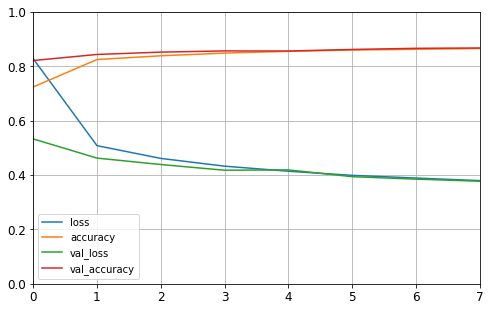

In [16]:
print_msg = "Momentum optimization"
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)
trainer(model, optimizer, n_epochs, loss, print_msg, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size)

Nesterov Accerlated Gradient


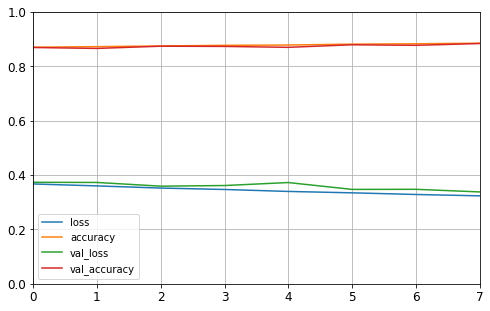

In [17]:
print_msg="Nesterov Accerlated Gradient"
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
trainer(model, optimizer, n_epochs, loss, print_msg, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size)

AdaGrad


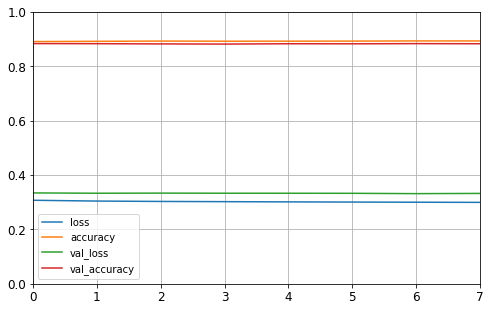

In [18]:
print_msg="AdaGrad"
optimizer = keras.optimizers.Adagrad(lr=0.001)
trainer(model, optimizer, n_epochs, loss, print_msg, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size)

RMSProp


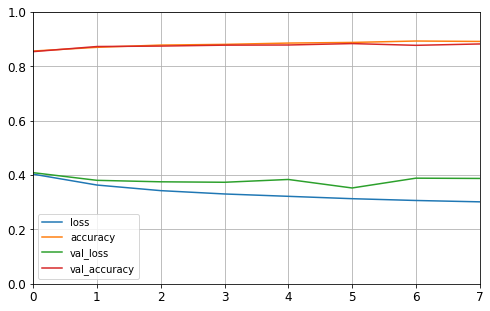

In [19]:
print_msg="RMSProp"
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)
trainer(model, optimizer, n_epochs, loss, print_msg, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size)

Adam Optimization


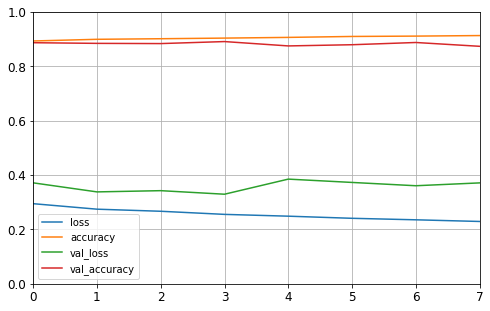

In [20]:
print_msg="Adam Optimization"
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
trainer(model, optimizer, n_epochs, loss, print_msg, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size)

Nadam Optimization


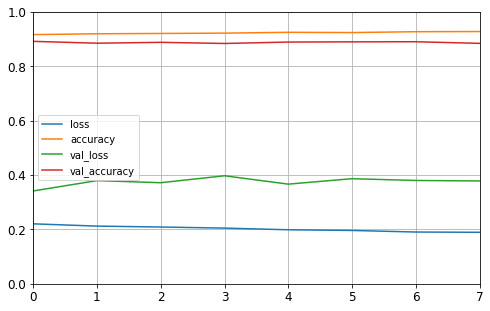

In [21]:
print_msg="Nadam Optimization"
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)
trainer(model, optimizer, n_epochs, loss, print_msg, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size)

## Parameter Initialization

While training a network, the initial value of the weights plays a significant role. In the extreme case, an oracle could just set the weights directly to values that minimize the objective function, and in practical cases a good initialization can bring us to a more favorable starting position in the parameter space. 

This raises the question of how to choose these weights. 

- What happens if all the weights are set to zero? The gradients become zero, and the network finds itself without a direction. 
- What if all of them are set to the same non-zero value? Although the gradients are no longer zero, each neuron has the same weight and follows the same gradient. Such neurons will continue to have the same value, since they're identical - it will not be easy to retrain them to display diversity.


**What are some of the initialization methods then?**


- **Random initialization**. Let's begin with creating a weight initialization function that samples from **N(0,1)**. A clean way of initializing the weights is to access the network parameters by traversing all modules inside the network, and then applying the desired initialization. This method also allows us to encapsulate all the initializations into a single function. Note that there is another guideline of random initialization from Stanford 231n course is to do `w=np.random.randn(n)*sqrt(2.0/n)` (but what is `n`?)

- **Xavier initialization**. Xavier initialization is a way of initializing the weights such that the variance of the inputs is the same as the variance of the outputs. At each layer, the $fan_{in}$ and $fan_{out}$ (i.e. input connections and output connections) might be different. Evidently, if the number of inputs is less, they will need to be multiplied with higher weights so that they can sum up to the product of a larger number of outputs with smaller weights. Thus Glorot and Bengio in their 2010 paper propose the Xavier initialization or Glorot initialization to be the normal distribution with mean $0$ and variance = $2/(fan_{in}+fan_{out})$ or a uniform distribution with the bound at $2/(fan_{in}+fan_{out})$, so that the variance of input and output in each layer will be roughly the same.

- **Pretraining**. You might also need to have specific methods to initialize the weights in different layers. For example, you might want to use a pretrained model like Alexnet to give your network a head start for visual recognition tasks. 

**What are the other motivations?**

(1) avoid blowing-up/diminishing gradients and hence allow higher learning rates, since extreme gradients are caused by extrem activation maps; (2) reduce (not remove) strong dependency on initialization.

**What are the other things to keep in mind?**
There is no single initializtion method that achieve the best performance empirically. But when you are comparing models with others, make sure you are using the same initialization - since those make a difference. Also note that the initializations suitable should take into account the activation functions

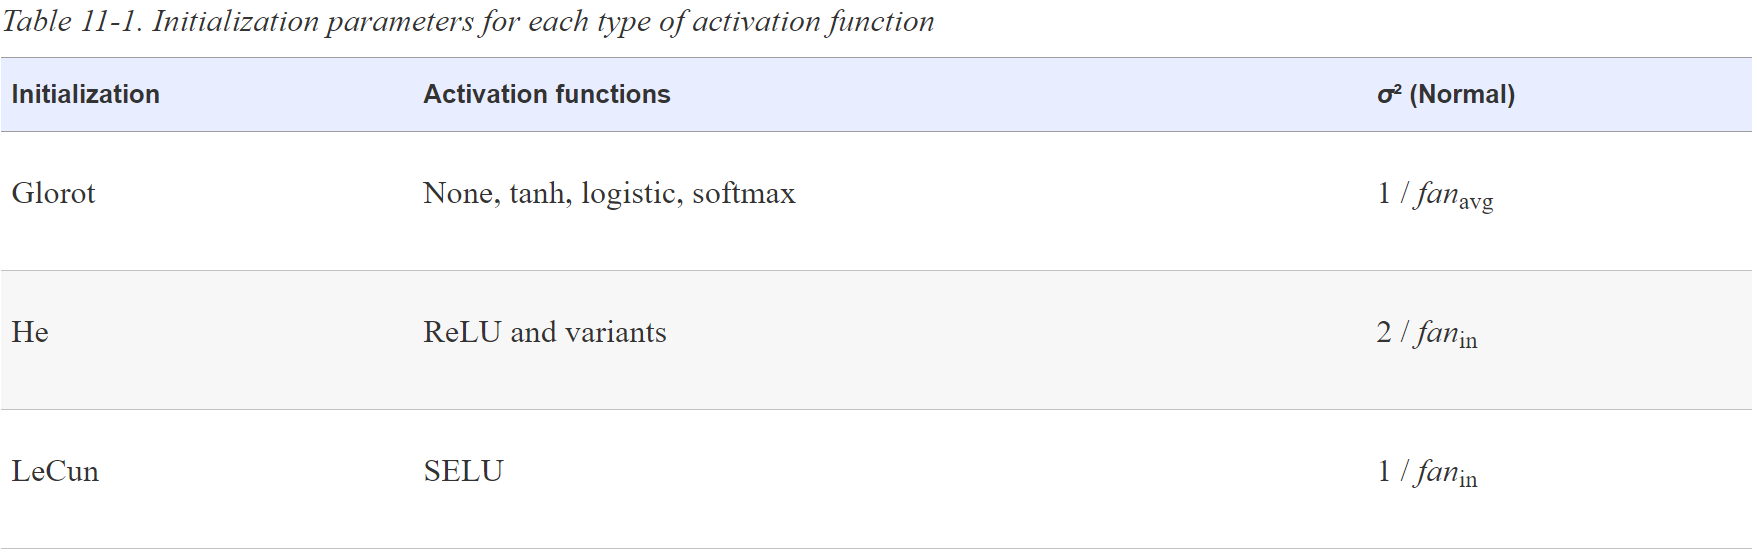

In `keras`, initializers can be specified in a layer by the `kernel_initializer` argument, or you can define your own initializer. By default, Keras uses Glorot initialization with a uniform distribution.

In [ ]:
# setting initializer as he normal
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal") 
# defining your own he initializer based on fan_avg
he_avg_init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                                 distribution='uniform')
keras.layers.Dense(10, activation="sigmoid", kernel_initializer=he_avg_init)

In [ ]:
### LET'S TRAIN ### - refresh this
n_epochs = 3

print("NORMAL INIT WEIGHTS")
AdamOptimizer = torch.optim.Adam(normalmodel.parameters(), lr=0.001)
normal_trainer = Trainer(normalmodel, AdamOptimizer)
normal_trainer.run(n_epochs)
normal_trainer.save_model('./normal_model.pt')
print('')


print("XAVIER INIT WEIGHTS")
AdamOptimizer = torch.optim.Adam(xaviermodel.parameters(), lr=0.001)
xavier_trainer = Trainer(xaviermodel, AdamOptimizer)
xavier_trainer.run(n_epochs)
xavier_trainer.save_model('./xavier_model.pt')
print('')

### VISUALIZATION ###
def training_plot(metrics):
    plt.figure(1)
    plt.plot([m.loss for m in metrics], 'b')
    plt.title('Training Loss')
    plt.show()

training_plot(normal_trainer.metrics)
training_plot(xavier_trainer.metrics)

In [ ]:
# Using pretrained weights of Alex net. - refresh this
alexnet_model = models.alexnet(pretrained=True)

## Batch Normalization


**What is it?**

Batch normalization is to normalize each mini-batch to be statistically similar to every other batch, by applying an affine combination of the batch of inputs, aggregating the statistics over that mini-batch and normalize the batch by these statistics.


**Why do we do it?**
This is to deal with a phenomenon in machine learning called *covariate shift*, which the covariate distribution is non-stationary (a) over the course of training, a common phenomenon in online learning; (b) or across mini-batches (imagine in the current examples, we have been seeing training examples of red outfit, but then some green ones arrive)

More generally, the distribution of individual node and layer activity shifts as the network parameters are updated. As an abstraction, we can consider each node's activity to be a covariate of the following nodes in the network. Thus we can think of the non-stationarity of node (and layer) activations as a sort of *internal covariate shift*. Why is internal covariate shift a problem? Each subsequent layer has to account for a shifting distribution of its inputs. For saturating non-linearities the problem becomes even more dire, as the shift in activity will more likely place the unit output in the saturated region of the non-linearity.

What is more, BatchNorm introduces some randomness in the final trained network, and generate an effect close to regularization. BatchNorm also avoids the blowing-up/diminishing gradients and hence also allow higher learning rates. 

**What other things to keep in mind?**

It is usually used after the affine transformation and before the activation, because you may lose info after the activation. But if activation produces input to other layers, it is also normal to apply BatchNorm.

In [ ]:
class BatchNorm(nn.Module):

    def __init__(self, num_features):
        super(BatchNorm, self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.weight = Parameter(torch.Tensor(num_features))
        self.bias = Parameter(torch.Tensor(num_features))
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))
        self.reset_parameters()

    def reset_parameters(self):
        self.running_mean.zero_()
        self.running_var.fill_(1)
        self.weight.data.uniform_()
        self.bias.data.zero_()

    def forward(self, x):
        pass

## Regularization

Weight decay specifies regularization in the neural network.

During training, a regularization term is added to the network's loss to compute the backpropagation gradient. The weight decay value determines how dominant this regularization term will be in the gradient computation.

The most usual form of regularizations are
    
 > **L2**, or **ridge**, which produces diffuse weights
    
 > **L1**, or **Lasso**, which produces sparse weights
    
 > **maxnorm**: Another form of regularization is to enforce an absolute upper bound on the magnitude of the weight vector for every neuron and use projected gradient descent to enforce the constraint. In practice, this corresponds to performing the parameter update as normal, and then enforcing the constraint by clamping the weight vector of every neuron. Typically the upper bounds are on orders of 3 or 4. Some people report improvements when using this form of regularization. One of its appealing properties is that network cannot “explode” even when the learning rates are set too high because the updates are always bounded. (Not sure if PyTorch has this regularization though).

As a rule of thumb, the more training examples you have, the weaker this term should be. The more parameters you have the higher this term should be.

There are also other more general forms of regularizations.

 > **Dropout** is that for the training phase, for each hidden layer, for each training sample and for each iteration, ignore (zero out) a random selection of neurons as well as its corresponding inputs/outputs. It is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data. It is considered a form of regularization since it conforms to the theme of introducing noise at the forward pass. It is a very efficient way of performing model averaging with neural networks - intuition why this works is similar to emsemble: different local minima are reached by different random samples. The term "dropout" refers to dropping out units in a neural network - note that you do not need to that in testing (in PyTorch, for `.eval` the toggle for dropout is turned off). Typical dropout probability is around 0.1 to 0.5. Note that for the original dropouts, inputs need to be scaled at training time; but nowadays, dropout is usually done in an **inverse version**, so that in testing time there is no scaling needed, for faster inference:

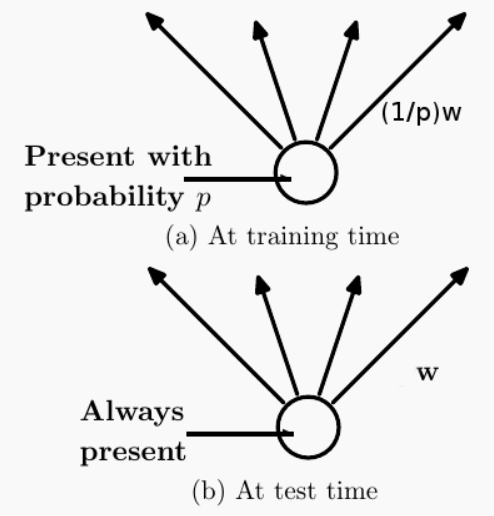


 
   > Note: dropout and BatchNorm cannot be used together, otherwise it leads to worse performance. This has to do with the variance shift between training and testing; see [Understanding the Disharmony between Dropout and Batch Normalization by
Variance Shift](https://arxiv.org/pdf/1801.05134.pdf)
   
 > **Early stopping**: in the general sense, it fits the theme of introducing noice to the training.

In [ ]:
### Example of a step decay

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

In [ ]:
### MODELS WITH BATCHNORM AND DROPOUT ###
class FashionModel_Tricks(nn.Module):
    
    def __init__(self):
        super(FashionModel_Tricks, self).__init__()
        self.fc1 = nn.Linear(784, 64)
        self.bnorm1 = nn.BatchNorm1d(64)
        self.dp1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(64, 32)
        self.bnorm2 = nn.BatchNorm1d(32)
        self.dp2 = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(32, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dp1(self.bnorm1(x))
        x = F.relu(self.fc2(x))
        x = self.dp2(self.bnorm2(x))
        x = F.log_softmax(self.fc3(x))
        return x
print(FashionModel_Tricks())

In [ ]:
### TRAIN MODELS WITH BATCHNORM AND DROPOUT ###
n_epochs = 10

model = FashionModel_Tricks()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.001)
btrainer = Trainer(model, optimizer)
btrainer.run(n_epochs)
btrainer.save_model('./dropout-batchnorm_optimized_model.pt')

training_plot(btrainer.metrics)

print('')

The `fit()` method accepts a callbacks argument that lets you specify a list of objects that Keras will call at the start and end of training, at the start and end of each epoch, and even before and after processing each batch. For example, the ModelCheckpoint callback saves checkpoints of your model at regular intervals during training, by default at the end of each epoch.

Moreover, if you use a validation set during training, you can set `save_best_only=True` when creating the ModelCheckpoint. In this case, it will only save your model when its performance on the validation set is the best so far. This way, you do not need to worry about training for too long and overfitting the training set: simply restore the last model saved after training, and this will be the best model on the validation set.

In [ ]:
### Use ModelCheckpoint to implement early stopping
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5",
                                                save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # roll back to best model

Another way to implement early stopping is to simply use the `EarlyStopping` callback. It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the `patience` argument), and it will optionally roll back to the best model. You can combine both callbacks to save checkpoints of your model (in case your computer crashes) and interrupt training early when there is no more progress (to avoid wasting time and resources). In this case, you do not need to restore to the best model saved.

In [ ]:
### Use early stopping directly
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])

`callback` on itself is pretty useful beyond early stopping or saving checkpoints; see `keras.callbacks` package.

## Gradient Clipping

During experimentation, once the gradient value grows extremely large, it causes an overflow (i.e. NaN) which is easily detectable at runtime or in a less extreme situation, the Model starts overshooting past our Minima; this issue is called the Gradient Explosion Problem.

Gradient clipping will ‘clip’ the gradients or cap them to a Threshold value to prevent the gradients from getting too large.

In [ ]:
#Gradient Clipping 
# `clip_grad_norm` helps prevent the exploding gradient problem. To be used before optimizer.step()during training
torch.nn.utils.clip_grad_norm(model.parameters(), 0.25)

## Hyperparameter Optimization

- Parallel the search and do early stopping.
- Prefer one validation fold to cross validation
- Search for hyperparameters on log scale
- Prefer random search to grid search
- Careful with best value that are on the border - look beyond the border!
- Stage your search from coarse to fine.

## Model Ensembles

- Same models. Different Initializations
- Top-model discovered during cross-validation
- Different checkpoints of a single model
- Running average of parameters during training

## References

- CMU Deep Learning Course Fall 2019.
- Stanford 231n
- <Hands-on Machine Learning with Scikit-Learn, Keras, and Tensorflow>, 2nd Edition. Chapters 10, 11.

### Further Reading

- Rprop and QuickProp in CMU course Fall 2019, Lecture 5.